In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
import os
import torch
from torchvision import transforms
from torch import nn
import numpy as np
import pandas as pd
from PIL import Image

## 1. Load Datasets

In [3]:
# main train and test datasets
columns = ['user_id', 'item_id', 'rating', 'timestamp']
train_df = pd.read_csv('data/ua.train', sep='\t', names=columns)
test_df = pd.read_csv('data/ua.test', sep='\t', names=columns)

# item information
item_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url'] + [f'genre_{i}' for i in range(19)]
items_df = pd.read_csv('data/u.item', sep='|', names=item_columns, encoding='latin-1')

# genre names for readability
genres_df = pd.read_csv('data/u.genre', sep='|', names=['genre', 'genre_id'])
genre_mapping = dict(zip(genres_df['genre_id'], genres_df['genre']))

for i in range(len(genres_df)):
    old_name = f'genre_{i}'
    new_name = genre_mapping[i]
    items_df = items_df.rename(columns={old_name: new_name})
    
    
# user information
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users_df = pd.read_csv('data/u.user', sep='|', names=user_columns)

# combine dataframes
train_df = train_df.merge(items_df, left_on='item_id', right_on='movie_id')
train_df = train_df.merge(users_df, on='user_id')

test_df = test_df.merge(items_df, left_on='item_id', right_on='movie_id')
test_df = test_df.merge(users_df, on='user_id')

In [4]:
print(train_df.shape)
print(test_df.shape)

(90570, 32)
(9430, 32)


## 2. Data cleaning

### Drop insignificant input features

In [7]:
train_df.describe()

,user_id,item_id,rating,timestamp,movie_id,video_release_date,unknown,Action,Adventure,Animation,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age
count,90570.000000,90570.000000,90570.000000,9.057000e+04,90570.000000,0.0,90570.000000,90570.000000,90570.000000,90570.000000,...,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000,90570.000000
mean,461.494038,428.104891,3.523827,8.835073e+08,428.104891,NaN,0.000099,0.255316,0.138103,0.036745,...,0.017423,0.053450,0.050348,0.051187,0.193364,0.126830,0.216054,0.093508,0.019079,32.857182
std,266.004364,333.088029,1.126073,5.341684e+06,333.088029,NaN,0.009968,0.436041,0.345010,0.188136,...,0.130842,0.224931,0.218663,0.220380,0.394938,0.332784,0.411554,0.291144,0.136804,11.489888
min,1.000000,1.000000,1.000000,8.747247e+08,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
25%,256.000000,174.000000,3.000000,8.794484e+08,174.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000
50%,442.000000,324.000000,4.000000,8.828143e+08,324.000000,NaN,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000
75%,682.000000,636.000000,4.000000,8.882049e+08,636.000000,NaN,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000
max,943.000000,1682.000000,5.000000,8.932866e+08,1682.000000,NaN,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,73.000000


In [8]:
train_df.drop(['user_id','item_id', 'movie_title','video_release_date','unknown','imdb_url'], axis=1, inplace=True)
test_df.drop(['user_id','item_id','movie_title','video_release_date','unknown','imdb_url'], axis=1, inplace=True)

In [9]:
numeric_columns = train_df.select_dtypes(include=['number']).columns
correlation = train_df[numeric_columns].corr()
correlation_styled = correlation.style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format("{:.2f}")
correlation_styled

,rating,timestamp,movie_id,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age
rating,1.00,-0.01,-0.19,-0.03,-0.01,0.01,-0.04,-0.08,0.03,0.01,0.11,-0.03,0.05,-0.05,0.00,0.02,0.04,0.01,-0.01,0.08,0.01,0.06
timestamp,-0.01,1.00,0.04,-0.01,-0.02,-0.02,-0.01,-0.02,0.00,0.00,0.03,-0.01,0.01,0.00,-0.00,0.03,0.01,-0.02,-0.00,-0.00,0.00,0.16
movie_id,-0.19,0.04,1.00,-0.15,-0.08,-0.03,-0.01,0.02,-0.10,0.06,0.01,0.04,0.02,-0.01,-0.02,0.01,-0.01,-0.17,-0.05,-0.11,-0.02,-0.01
Action,-0.03,-0.01,-0.15,1.00,0.45,-0.10,-0.14,-0.22,0.01,-0.05,-0.27,-0.01,-0.08,-0.01,-0.09,-0.03,-0.02,0.32,0.25,0.16,0.06,-0.07
Adventure,-0.01,-0.02,-0.08,0.45,1.00,-0.02,0.10,-0.11,-0.03,-0.03,-0.22,0.09,-0.05,-0.06,-0.03,-0.04,-0.02,0.29,-0.05,0.08,0.01,-0.03
Animation,0.01,-0.02,-0.03,-0.10,-0.02,1.00,0.56,0.03,-0.06,-0.02,-0.16,0.03,-0.03,-0.03,0.42,-0.05,-0.09,-0.04,-0.08,-0.06,-0.03,-0.03
Children's,-0.04,-0.01,-0.01,-0.14,0.10,0.56,1.00,0.08,-0.08,-0.02,-0.13,0.24,-0.04,-0.07,0.39,-0.06,-0.12,-0.04,-0.14,-0.09,-0.03,-0.03
Comedy,-0.08,-0.02,0.02,-0.22,-0.11,0.03,0.08,1.00,-0.09,-0.06,-0.35,0.02,-0.09,-0.07,0.04,-0.11,0.10,-0.15,-0.29,-0.12,0.00,-0.03
Crime,0.03,0.00,-0.10,0.01,-0.03,-0.06,-0.08,-0.09,1.00,-0.03,0.06,0.01,0.16,-0.02,-0.07,0.08,-0.10,-0.09,0.12,-0.09,-0.04,-0.01
Documentary,0.01,0.00,0.06,-0.05,-0.03,-0.02,-0.02,-0.06,-0.03,1.00,-0.06,-0.01,-0.01,-0.02,-0.02,-0.02,-0.04,-0.03,-0.05,-0.01,-0.01,0.01


## 3. Feature engineering

In [11]:
# like & dislike (binary target variable)
train_df['like_dislike'] = train_df['rating'].apply(lambda x: 1 if x >= 4 else 0)
test_df['like_dislike'] = test_df['rating'].apply(lambda x: 1 if x >= 4 else 0)

# one-hot encoding 'gender', 'occupation'
train_df = pd.get_dummies(train_df, columns=['gender', 'occupation'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['gender', 'occupation'], drop_first=True)

# convert release date to movie age
train_df['rating_date'] = pd.to_datetime(train_df['timestamp'], unit='s')
train_df['release_date'] = pd.to_datetime(train_df['release_date'], format='%d-%b-%Y', errors='coerce')
train_df['movie_age'] = (train_df['rating_date'] - train_df['release_date']).dt.days

test_df['rating_date'] = pd.to_datetime(test_df['timestamp'], unit='s')
test_df['release_date'] = pd.to_datetime(test_df['release_date'], format='%d-%b-%Y', errors='coerce')
test_df['movie_age'] = (test_df['rating_date'] - test_df['release_date']).dt.days

# standardise user age and movie age
from sklearn.preprocessing import StandardScaler
scaler_age = StandardScaler()
scaler_movie_age = StandardScaler()

train_df['age'] = scaler_age.fit_transform(train_df[['age']])
test_df['age'] = scaler_age.transform(test_df[['age']]) 

train_df['movie_age'] = scaler_movie_age.fit_transform(train_df[['movie_age']])
test_df['movie_age'] = scaler_movie_age.transform(test_df[['movie_age']]) 

In [12]:
train_df.head()

,rating,timestamp,movie_id,release_date,Action,Adventure,Animation,Children's,Comedy,Crime,...,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,rating_date,movie_age
0,5,874965758,1,1995-01-01,0,0,1,1,1,0,...,False,False,False,False,False,False,True,False,1997-09-22 22:02:38,-0.513217
1,3,876893171,2,1995-01-01,1,1,0,0,0,0,...,False,False,False,False,False,False,True,False,1997-10-15 05:26:11,-0.508826
2,4,878542960,3,1995-01-01,0,0,0,0,0,0,...,False,False,False,False,False,False,True,False,1997-11-03 07:42:40,-0.505199
3,3,876893119,4,1995-01-01,1,0,0,0,1,0,...,False,False,False,False,False,False,True,False,1997-10-15 05:25:19,-0.508826
4,3,889751712,5,1995-01-01,0,0,0,0,0,1,...,False,False,False,False,False,False,True,False,1998-03-13 01:15:12,-0.480384


In [13]:
train_df.drop(['rating','timestamp','movie_id','release_date','rating_date','zip_code'], axis=1, inplace=True)
test_df.drop(['rating','timestamp','movie_id','release_date','rating_date','zip_code'], axis=1, inplace=True)

# train_df.drop(['rating','timestamp','movie_id','release_date','zip_code'], axis=1, inplace=True)
# test_df.drop(['rating','timestamp','movie_id','release_date','zip_code'], axis=1, inplace=True)

In [14]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90562 entries, 0 to 90569
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Action                    90562 non-null  int64  
 1   Adventure                 90562 non-null  int64  
 2   Animation                 90562 non-null  int64  
 3   Children's                90562 non-null  int64  
 4   Comedy                    90562 non-null  int64  
 5   Crime                     90562 non-null  int64  
 6   Documentary               90562 non-null  int64  
 7   Drama                     90562 non-null  int64  
 8   Fantasy                   90562 non-null  int64  
 9   Film-Noir                 90562 non-null  int64  
 10  Horror                    90562 non-null  int64  
 11  Musical                   90562 non-null  int64  
 12  Mystery                   90562 non-null  int64  
 13  Romance                   90562 non-null  int64  
 14  Sci-Fi     

In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9429 entries, 0 to 9429
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Action                    9429 non-null   int64  
 1   Adventure                 9429 non-null   int64  
 2   Animation                 9429 non-null   int64  
 3   Children's                9429 non-null   int64  
 4   Comedy                    9429 non-null   int64  
 5   Crime                     9429 non-null   int64  
 6   Documentary               9429 non-null   int64  
 7   Drama                     9429 non-null   int64  
 8   Fantasy                   9429 non-null   int64  
 9   Film-Noir                 9429 non-null   int64  
 10  Horror                    9429 non-null   int64  
 11  Musical                   9429 non-null   int64  
 12  Mystery                   9429 non-null   int64  
 13  Romance                   9429 non-null   int64  
 14  Sci-Fi       

In [17]:
train_df.describe()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age,like_dislike,movie_age
count,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,...,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,90562.000000,9.056200e+04
mean,0.255339,0.138115,0.036748,0.072525,0.300093,0.080155,0.007575,0.397639,0.013736,0.017425,...,0.050352,0.051191,0.193381,0.126841,0.216073,0.093516,0.019081,0.000051,0.551026,3.452207e-18
std,0.436054,0.345023,0.188144,0.259356,0.458301,0.271535,0.086704,0.489413,0.116395,0.130848,...,0.218672,0.220389,0.394952,0.332797,0.411567,0.291156,0.136810,1.000027,0.497392,1.000006e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.250442,0.000000,-7.590825e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.770872,0.000000,-6.101887e-01
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.248671,1.000000,-4.332340e-01
75%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.621665,1.000000,1.258815e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.493771,1.000000,4.616177e+00


In [18]:
train_df.head(15)

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,movie_age
0,0,0,1,1,1,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,-0.513217
1,1,1,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,-0.508826
2,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,False,False,True,False,-0.505199
3,1,0,0,0,1,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,-0.508826
4,0,0,0,0,0,1,0,1,0,0,...,False,False,False,False,False,False,False,True,False,-0.480384
5,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,-0.485538
6,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,-0.512835
7,0,0,0,1,1,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,-0.512835
8,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,-0.505199
9,0,0,0,0,0,0,0,1,0,0,...,False,False,False,False,False,False,False,True,False,-0.585182


## 4. Multi Layer Perceptron model

In [20]:
def validation(model, test_loader, criterion):
    model.eval() 
    # Initialize variables to keep track of the number of examples, accumulated loss, and accumulated accuracy.
    num, acc_loss, acc_acc = 0, 0, 0

    # Iterate through the test loader to evaluate the model on the test data.
    for data, target in test_loader:
        num += 1
        
        # Forward pass: Compute predictions from the model.
        pred = model(data)
        
        # Calculate the loss between the predictions and the target labels.
        loss = criterion(pred, target.view(-1, 1))
        
        # Calculate accuracy by comparing predicted values with the target labels.
        acc = (torch.sigmoid(pred).round().view(-1) == target).float().mean()
        
        # Accumulate loss and accuracy values for later averaging.
        acc_loss += loss.item()
        acc_acc += acc.item()
    
    # Calculate the average loss and accuracy across all batches in the test data.
    avg_loss = acc_loss / num
    avg_acc = acc_acc / num
    
    return avg_loss, avg_acc

In [21]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, num_features):
        super(MLP, self).__init__()
        
        # Define the layers of the MLP
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),  # Input layer size should match num_features
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Dropout layer with 50% dropout rate
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # Single output neuron for binary classification
        )

    def forward(self, x):
        return self.classifier(x)  # Output logits for BCEWithLogitsLoss


In [22]:
import torch
import torch.nn as nn
import os
from torch.utils.data import TensorDataset, DataLoader

def train_model(model, train_loader, valid_loader, lr, bz, num_epoch, optim='Adam', verbose=True, print_freq=10):
    # Set up directory to save model checkpoints
    dir = 'model_' + model.__class__.__name__ + '/'
    if not os.path.exists(dir):
        os.makedirs(dir)

    # # Define the loss function
    # criterion = nn.BCEWithLogitsLoss()
    # Calculate the weight for the minority class (Dislike)
    pos_weight = torch.tensor([len(train_df[train_df['like_dislike'] == 0]) / len(train_df[train_df['like_dislike'] == 1])])
    # Define the loss with class weight for balancing
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


     # Select the optimizer (Adam or SGD)
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        
    # Initialize tracking for best model based on validation loss
    best_loss, best_test_acc = float('inf'), 0.0

    # Training loop
    losses = []
    for epoch in range(num_epoch):
        model.train()  # Set model to training mode
        acc_loss, acc_acc, num_batches = 0, 0, 0

        for data, target in train_loader:
            num_batches += 1
            
            # Forward pass: Compute predictions from the model
            pred = model(data)
            
            # Calculate the loss and perform backpropagation
            loss = criterion(pred, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            acc = (torch.sigmoid(pred).round() == target).float().mean()
            acc_loss += loss.item()
            acc_acc += acc.item()

        # Validation step
        model.eval()
        test_loss, test_acc = validation(model, valid_loader, criterion)
        if test_loss < best_loss:
            best_loss = test_loss
            best_test_acc = test_acc
            torch.save(model.state_dict(), os.path.join(dir, "best_val.model"))

        # Print progress
        if verbose and epoch % print_freq == 0:
            print(f'[Epoch: {epoch}], loss = {acc_loss/num_batches}, acc = {acc_acc/num_batches}, valid acc = {test_acc}')
        losses.append(acc_loss/num_batches)

    # Load best model and evaluate
    model.load_state_dict(torch.load(os.path.join(dir, "best_val.model")))
    test_loss, test_best_acc = validation(model, valid_loader, criterion)
    print(f'The best Validation acc is {test_best_acc}')
    
    return losses


## 5. Model training

In [24]:
# Assume num_features is the number of columns in your input dataset
num_features = train_df.shape[1] - 1  # Exclude target column if included in train_df
movie_model = MLP(num_features)

# Convert boolean columns to int8
bool_columns = train_df.select_dtypes(include=['bool']).columns
train_df[bool_columns] = train_df[bool_columns].astype('int8')
test_df[bool_columns] = test_df[bool_columns].astype('int8')

# Create train and validation DataLoaders from preprocessed DataFrames
from torch.utils.data import TensorDataset, DataLoader

# Convert DataFrames to tensors for DataLoaders
X_train_tensor = torch.tensor(train_df.drop(columns=['like_dislike']).values, dtype=torch.float32)
y_train_tensor = torch.tensor(train_df['like_dislike'].values, dtype=torch.float32).view(-1, 1)

X_valid_tensor = torch.tensor(test_df.drop(columns=['like_dislike']).values, dtype=torch.float32)
y_valid_tensor = torch.tensor(test_df['like_dislike'].values, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
valid_data = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=len(y_valid_tensor), shuffle=False)

# Train the model
losses = train_model(movie_model, train_loader, valid_loader, lr=0.01, bz=16, num_epoch=20, print_freq=5)

# Store the loss history for reference
models = {'movie_binary_model': losses}


[Epoch: 0], loss = 0.608677343607454, acc = 0.5833222987288136, valid acc = 0.5181624293327332
[Epoch: 5], loss = 0.6026384784803216, acc = 0.6032838983050848, valid acc = 0.5241459608078003
[Epoch: 10], loss = 0.6005023151299375, acc = 0.6096508651129944, valid acc = 0.5317906141281128
[Epoch: 15], loss = 0.6004386296927255, acc = 0.6100812146892656, valid acc = 0.5139756798744202
The best Validation acc is 0.5317906141281128


/var/folders/85/3q25ml057m51x2d6fx8s4w740000gn/T/ipykernel_73470/3718000884.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi

### 5. Evaluation

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate model on test data
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():  # No need to compute gradients during evaluation
        for data, target in test_loader:
            # Forward pass to get predictions
            outputs = model(data)
            preds = torch.sigmoid(outputs).round()  # Convert logits to binary predictions
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

    # Calculate precision, recall, and F1-score
    precision = precision_score(all_targets, all_preds)
    recall = recall_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)

    return precision, recall, f1

# Run evaluation on validation (test) data
precision, recall, f1 = evaluate_model(movie_model, valid_loader)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Precision: 0.6422
Recall: 0.7740
F1 Score: 0.7019


In [27]:
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix

# Function to calculate lift and cumulative lift
def calculate_lift(y_true, y_probs, thresholds):
    total_positive_rate = np.mean(y_true)
    lift_values = []
    cumulative_lift_values = []
    
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate lift
        tp = cm[1, 1]
        predicted_positive = y_pred.sum()
        if predicted_positive == 0:
            lift = 0
        else:
            positive_rate_in_predicted = tp / predicted_positive
            lift = positive_rate_in_predicted / total_positive_rate
        
        lift_values.append(lift)
        
        # Calculate cumulative lift (average lift up to this threshold)
        cumulative_lift = np.mean(lift_values)
        cumulative_lift_values.append(cumulative_lift)
    
    return lift_values, cumulative_lift_values

# Function to calculate Youden’s index
def calculate_youden_index(y_true, y_probs, thresholds):
    youden_indices = []
    for threshold in thresholds:
        y_pred = (y_probs >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate sensitivity and specificity
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        youden_index = sensitivity + specificity - 1
        youden_indices.append(youden_index)
    
    return youden_indices

# Generate probabilities and actual labels from test data
all_probs = []
all_targets = []

with torch.no_grad():
    for data, target in valid_loader:
        outputs = movie_model(data)
        probs = torch.sigmoid(outputs).view(-1).cpu().numpy()  # Probabilities
        all_probs.extend(probs)
        all_targets.extend(target.view(-1).cpu().numpy())

# Define thresholds for evaluation
thresholds = np.linspace(0.1, 0.9, 9)

# Calculate lift, cumulative lift, and Youden’s index across thresholds
lift_values, cumulative_lift_values = calculate_lift(np.array(all_targets), np.array(all_probs), thresholds)
youden_indices = calculate_youden_index(np.array(all_targets), np.array(all_probs), thresholds)

# Display results
print("Threshold\tLift\tCumulative Lift\tYouden's Index")
for i, threshold in enumerate(thresholds):
    print(f"{threshold:.2f}\t\t{lift_values[i]:.4f}\t{cumulative_lift_values[i]:.4f}\t\t{youden_indices[i]:.4f}")


Threshold	Lift	Cumulative Lift	Youden's Index
0.10		1.0002	1.0002		0.0005
0.20		1.0014	1.0008		0.0034
0.30		1.0047	1.0021		0.0110
0.40		1.0259	1.0080		0.0578
0.50		1.1074	1.0279		0.1787
0.60		1.2973	1.0728		0.1139
0.70		1.3842	1.1173		0.0566
0.80		1.4631	1.1605		0.0154
0.90		1.7244	1.2232		0.0011


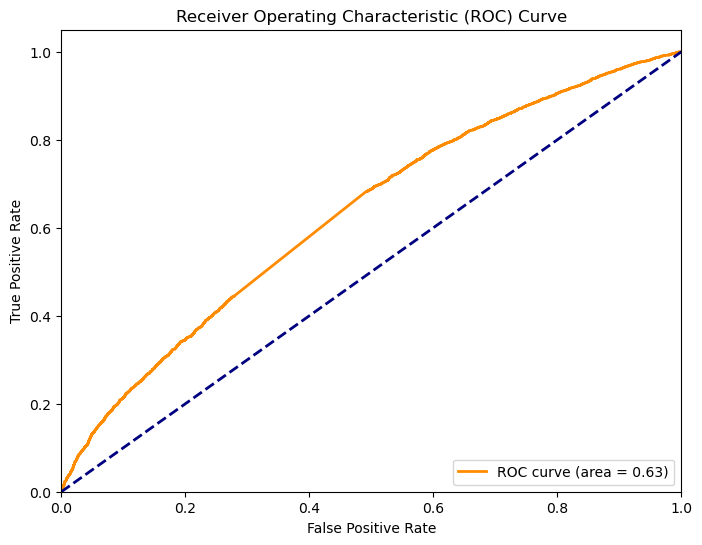

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate predictions and true labels
all_probs = []
all_targets = []

with torch.no_grad():
    for data, target in valid_loader:
        outputs = movie_model(data)
        probs = torch.sigmoid(outputs).view(-1).cpu().numpy()  # Probabilities
        all_probs.extend(probs)
        all_targets.extend(target.view(-1).cpu().numpy())

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(all_targets, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()